In [10]:
from finlab.data import Data
import pandas as pd
import datetime
data = Data()

# 策略
    * 中小型股：市值<100億
    * 自由現金流（＝營業現金收入-投資現金流出）（＝賣東西賺的錢-更新廠房、設備得錢） > 0
    * 營業利益成長率 ：[（當期營業利益 -  去年同期營業利益）/ 去年同期營業利益 ] * 100 % > 0
        *  營業利益(Operating profit =Operating income  )= 營收- 銷貨(營業)成本- 營業費用  ＝毛利 -營業費用
        * 屬於公司自比
    * 股東權益報酬率 （ＲＯＥ）＝ 本期淨利 / 股東權益  ＝ 稅後淨利 / 權益總計
        * 缺點：更新太慢、未考慮股價 
        * 大部分再0~10
    * 市值營收比（ＰＳＲ ＝price to sale ratio）= 市值 / 月營收 
        * 越高越不好
        * 大部分在0~1

# 條件一：公司的市值

In [11]:
# 先拿出計算市值需要用到的財務數據

股本 = data.get('股本合計', 1)
price = data.get('收盤價', 100)

# ----------- #
# 找出當天股價  #
# ----------- #

# 新版（較簡單）：將頻率為「天」的股價，reindex 成每「季」
# method='fill'是說，假如公佈財報那天沒有股價，則以時間往前最接近的那天為主。

當天股價 = price.reindex(股本.index, method='ffill').iloc[-1]

# 原本（較難）：當天股價 = price.loc[:股本.index[0]].iloc[-1]

# ----------- #
# 找出當天股本  #
# ----------- #

當天股本 = 股本.iloc[-1]

# -----------  #
# 計算市值      #
# -----------  #

# 市值 = 總股數 * 股價
#     = （股本 * 1000） / 10 * 股價

市值 = 當天股本 * 1000 / 10 * 當天股價
市值['1101']

263129734400.0

# 條件二：自由現金流


In [12]:
# 將每季累計的財務數據，轉換成單季
def toSeasonal(df):
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]
    season4 = df[df.index.month == 3]
    
    
    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1
    
    NewSeason1 = season1
    NewSeason2 = season2 - season1.reindex_like(season2)
    NewSeason3 = season3 - season2.reindex_like(season3)
    NewSeason4 = season4 - season3.reindex_like(season4)
    
    
    
    NewSeason1.index = pd.to_datetime(NewSeason1.index.astype(str) + '-05-15')
    NewSeason2.index = pd.to_datetime(NewSeason2.index.astype(str) + '-08-14')
    NewSeason3.index = pd.to_datetime(NewSeason3.index.astype(str) + '-11-14')
    NewSeason4.index = pd.to_datetime((NewSeason4.index + 1).astype(str) + '-03-31')

    
    return NewSeason1.append(NewSeason2).append(NewSeason3).append(NewSeason4).sort_index()
    
    
#自由現金流（＝營業現金收入+投資現金流入 )


營業活動之現金流入 = data.get('營業活動之淨現金流入（流出）',8)
#營業現金收入
    
投資活動之現金流入 = data.get('投資活動之淨現金流入（流出）', 8)    
#投資活動之現金流入 


投資現金流 = toSeasonal(投資活動之現金流入)
營業現金流 = toSeasonal(營業活動之現金流入)
#轉換成每季 


自由現金流 = (投資現金流 + 營業現金流).iloc[-4:].sum()
#變成一條series
    


# 條件三：股東權益報酬率

In [13]:
稅後淨利 = data.get('本期淨利（淨損）', 1)

# 因為有些股東權益的名稱叫作「權益總計」有些叫作「權益總額」，所以要先將這兩個dataframe合併起來
權益總計 = data.get('權益總計', 1)
權益總額 = data.get('權益總額', 1)

# 把它們合併起來（將「權益總計」為NaN的部分填上「權益總額」）
權益總計.fillna(權益總額, inplace=True)

股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
股東權益報酬率.describe()

count    1753.000000
mean        0.018414
std         0.088967
min        -2.076294
25%         0.004963
50%         0.023502
75%         0.042453
max         0.513252
Name: 2022-05-15 00:00:00, dtype: float64

# 條件四：營業利益成長率

In [14]:
營業利益 = data.get('營業利益（損失）', 5)
營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
營業利益成長率.describe()

count     1708.000000
mean        14.021841
std        716.509396
min      -6484.905660
25%        -54.692829
50%         -1.865090
75%         47.636605
max      17728.571429
dtype: float64

# 條件五：市值營收比

In [15]:
%matplotlib inline
當月營收 = data.get('當月營收', 4) * 1000
當季營收 = 當月營收.iloc[-4:].sum() # 取近4個月營收總和，當作一季的月營收（4也可以改變）
市值營收比 = 市值 / 當季營收
市值營收比.describe()

count       951.000000
mean        183.367182
std        4945.110824
min          -3.761379
25%           2.794852
50%           4.804469
75%           9.514920
max      152380.412000
dtype: float64

# 結合上述五個條件選股

In [18]:
condition1 = (市值 < 10000000000)
condition2 = 自由現金流 > 0
condition3 = 股東權益報酬率 > 0
condition4 = 營業利益成長率 > 0
condition5 = 市值營收比 < 5

# 將條件做交集（&）
select_stock = condition1 & condition2 & condition3 & condition4 & condition5 

# 選出的股票
select_stock[select_stock]

stock_id
1108    True
1203    True
1217    True
1413    True
1452    True
1457    True
1516    True
1517    True
1527    True
1539    True
1568    True
1612    True
1615    True
1730    True
1906    True
2012    True
2032    True
2062    True
2243    True
2321    True
2364    True
2369    True
2399    True
2453    True
2468    True
2543    True
2546    True
2601    True
2936    True
3043    True
3046    True
3052    True
3338    True
3437    True
3535    True
4306    True
4552    True
4557    True
4960    True
4989    True
5258    True
5284    True
5533    True
5906    True
6128    True
6152    True
6192    True
6197    True
6215    True
6281    True
6438    True
6754    True
6776    True
8070    True
8271    True
9927    True
dtype: bool

# 綜合上述策略：mystrategy 做成function

In [19]:
def mystrategy(data):
    
    股本 = data.get('股本合計', 1)
    price = data.get('收盤價', 120)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5
    
    return select_stock[select_stock]

# 回測

2017-01-01 - 2017-03-02 報酬率: 7.40 % nstock 127
2017-03-02 - 2017-05-01 報酬率: 2.09 % nstock 126
2017-05-01 - 2017-06-30 報酬率: 2.46 % nstock 102
2017-06-30 - 2017-08-29 報酬率: 4.69 % nstock 83
2017-08-29 - 2017-10-28 報酬率: 5.49 % nstock 82
2017-10-28 - 2017-12-27 報酬率: 3.12 % nstock 82
2017-12-27 - 2018-02-25 報酬率: 1.56 % nstock 88
2018-02-25 - 2018-04-26 報酬率: 1.38 % nstock 86
每次換手最大報酬 : 7.40 ％
每次換手最少報酬 : 1.38 ％


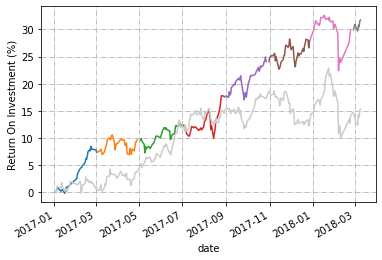

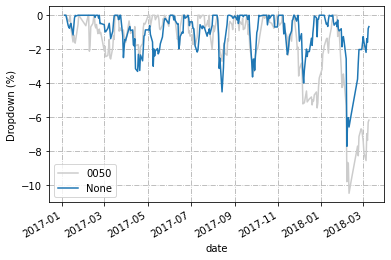

(2017-01-04    1.000000
 2017-01-05    1.006241
 2017-01-06    1.009988
 2017-01-09    1.004098
 2017-01-10    1.002802
                 ...   
 2018-03-05    1.297182
 2018-03-06    1.307829
 2018-03-07    1.305008
 2018-03-08    1.315819
 2018-03-09    1.317281
 Length: 283, dtype: float64,
           buy_price  sell_price  lowest_price  highest_price   buy_date  \
 stock_id                                                                  
 1203          22.90       23.90         22.85          24.35 2017-01-04   
 1218          15.05       15.10         14.90          15.65 2017-01-04   
 1231          32.00       31.85         31.65          32.55 2017-01-04   
 1310          19.90       22.10         19.40          24.15 2017-01-04   
 1323          34.10       34.05         32.60          34.35 2017-01-04   
 ...             ...         ...           ...            ...        ...   
 8467          32.00       31.50         31.50          32.40 2018-02-27   
 9911          37.75  

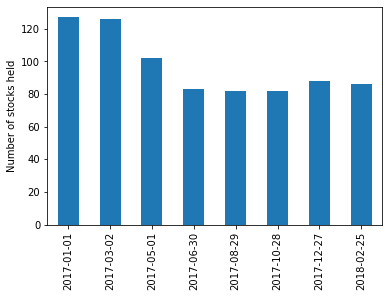

In [20]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime

#此為Finlab回測模組 之後需練習自己刻出
%matplotlib inline
data = Data()
backtest(datetime.date(2017,1,1), datetime.date(2018,3,10), 60, mystrategy, data)